# Final Report - Group 35

## Introduction

The National Basketball Association (NBA) is a professional basketball league with 30 teams from the United States and Canada. Every year, teams play 82 games in the regular season followed by a best of 7 series in each round of the playoffs with the hopes of claiming the championship trophy. 

The five active players during a game are: Point Guard, Shooting Guard, Small Forward, Power Forward, and Center. Point guards run the offense and are the team's best passers and dribblers, whereas shooting guards are the team's most proficient shooters. However, Point Guards and Shooting Guards, collectively referred to as "guards", score the majority of three-pointers, followed by Small Forwards, Power Forwards, and Centers. In recent years, point guards have caught up to shooting guards in scoring three-pointers, which raises the question of where to position a good shooter.

We will analyze the NBA player stats for the 2017-18 season, which contains information about a player's position, three-pointers made, games played, etc. for 490 unique players in the NBA, to try and determine whether there is a difference in the median number of three-point shots made per game by all Point Guards and Shooting Guards that in the NBA.

We believe this question is critical as it could assist coaches in deciding where to play their finest three-point shooter. As such, our population of interest is comprised of all current and future point guards and shooting guards in the NBA. The data from this season is a random cluster sample, and is likely to be representative of the population.

## Methods and Results
### Overview
1. **Reading, Wrangling and Cleaning:** Loading the dataset from the web, removing irrelevant variables, filtering out non-guard positions and standardizing variable of interest.
2. **Exploratory Data Analysis:** Computing summary statistics of variable of interest across the chosen categories, and visualizing the sample distribution.

3. **Hypothesis Test:** Conducting a theory-based one-sided hypothesis test based on chosen variable of interest and categories.

4. **Comparison with Confidence Interval:** Comparing the results of the hypothesis test with a 95% confidnece interval for difference in medians both through bootstrapping.  
    
5. **Results and Analysis:** Analyzing and summarizing the results.
### Loading Libraries

In [1]:
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)
library(digest)
library(testthat)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches




### Reading, Cleaning and Wrangling 
We begin by setting the seed to 35, reading our dataset from web and saving it to `nba_stats`.

In [2]:
# Setting the seed
set.seed(35)

# Reading in the raw data
nba_stats <- read_csv("https://raw.githubusercontent.com/Ne1sonLi/STAT-201-Project-Group-35/main/players_stats.csv")

# Display the first 6 rows of the raw data
head(nba_stats)

Rows: 490 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): Name, Birth_Place, Birthdate, Collage, Experience, Pos, Team
dbl (27): Games Played, MIN, PTS, FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,⋯,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
AJ Price,26,324,133,51,137,37.2,15,57,26.3,⋯,29,us,"October 7, 1986",University of Connecticut,5,185.0,PG,PHO,81.45,23.79839
Aaron Brooks,82,1885,954,344,817,42.1,121,313,38.7,⋯,30,us,"January 14, 1985",University of Oregon,6,180.0,PG,CHI,72.45,22.36111
Aaron Gordon,47,797,243,93,208,44.7,13,48,27.1,⋯,20,us,"September 16, 1995",University of Arizona,R,202.5,PF,ORL,99.00,24.14266
Adreian Payne,32,740,213,91,220,41.4,1,9,11.1,⋯,24,us,"February 19, 1991",Michigan State University,R,205.0,PF,ATL,106.65,25.37775
Al Horford,76,2318,1156,519,965,53.8,11,36,30.6,⋯,29,do,"June 3, 1986",University of Florida,7,205.0,C,ATL,110.25,26.23438
Al Jefferson,65,1992,1082,486,1010,48.1,2,5,40.0,⋯,30,us,"January 4, 1985",NA,10,205.0,C,CHA,130.05,30.94587


To tidy the data, we select the rows with `PG` or `SG` in `Pos`. Then we removed obervations with `NA` values before dividing three-pointers made (`3PM`) by the number of games played (`Games Played`). We standardized the data because the number of point guards may not be the same as the number of shooting guards, and different players may have played a different number of games. Thus, simply comparing the number of three-pointers made will lead to inaccurate results.

In [3]:
# Filtering out observations that have NA
# Standardized by dividing 3 pointers made (3PM) by the games played (Games Played)
tidy_nba <- nba_stats |> 
    rename(pos = Pos) |>
    filter(pos == "PG" | pos == "SG") |>
    filter(!is.na('3PM') | !is.na('Games Played')) |>
    mutate(three_pts_standardized = `3PM`/ `Games Played`) |>
    select(pos, three_pts_standardized)

# Display first 6 rows of the tidy data
head(tidy_nba)

pos,three_pts_standardized
<chr>,<dbl>
PG,0.5769231
PG,1.4756098
SG,0.9864865
SG,0.9629630
SG,1.1190476
SG,0.5882353


### Exploratory Data Analysis
Now that our dataset is in a tidy format relevant to our analysis, we will look at the summary statistics of `three_pts_standardized` across each guard position.

In [4]:
# Summarizing the data frame
nba_summary <- tidy_nba |>
    group_by(pos) |>
    summarize(median_three_pts = median(three_pts_standardized),
              mean_three_pts = mean(three_pts_standardized),
              sd_three_pts = sd(three_pts_standardized),
              n = n(),
              var_three_pts = var(three_pts_standardized))

print("Table 1.1 : NBA Data Summary")
nba_summary

[1] "Table 1.1 : NBA Data Summary"


pos,median_three_pts,mean_three_pts,sd_three_pts,n,var_three_pts
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
PG,0.7569223,0.8862508,0.6582483,84,0.4332908
SG,0.9009952,1.0099519,0.7369353,100,0.5430736


Here we see that the sample mean for Shooting Guards is greater than the sample mean for Point Guards. We also note that both `PG` and `SG` have a higher `mean_three_pts` than `median_three_pts` which could indicate that the distribution is right skewed.

We now examine the distribution of three-pointers for point guards and shootings separately with histograms and boxplots.

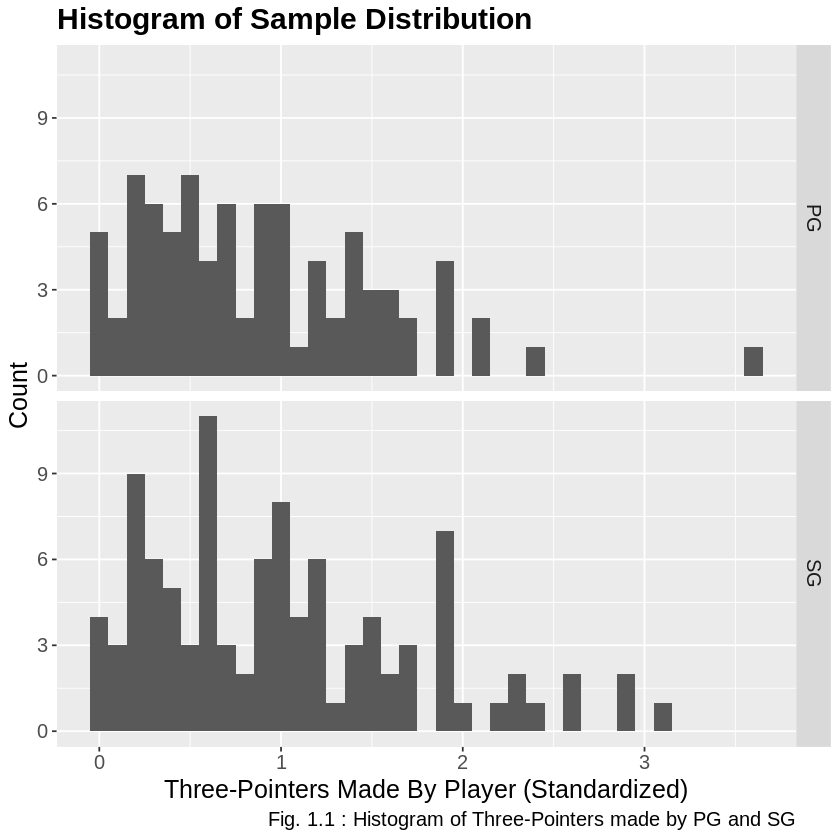

In [5]:
# Plotting the sample distribution using a histogram
options(repr.plot.width = 7, repr.plot.height = 7)

three_point_dist <- tidy_nba |> 
    ggplot(aes(x = three_pts_standardized)) + 
    geom_histogram(binwidth = .1) + 
    xlab("Three-Pointers Made By Player (Standardized)") +
    ylab("Count") +
    labs(caption = "Fig. 1.1 : Histogram of Three-Pointers made by PG and SG") +
    facet_grid(rows = vars(pos)) + 
    ggtitle("Histogram of Sample Distribution") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

three_point_dist

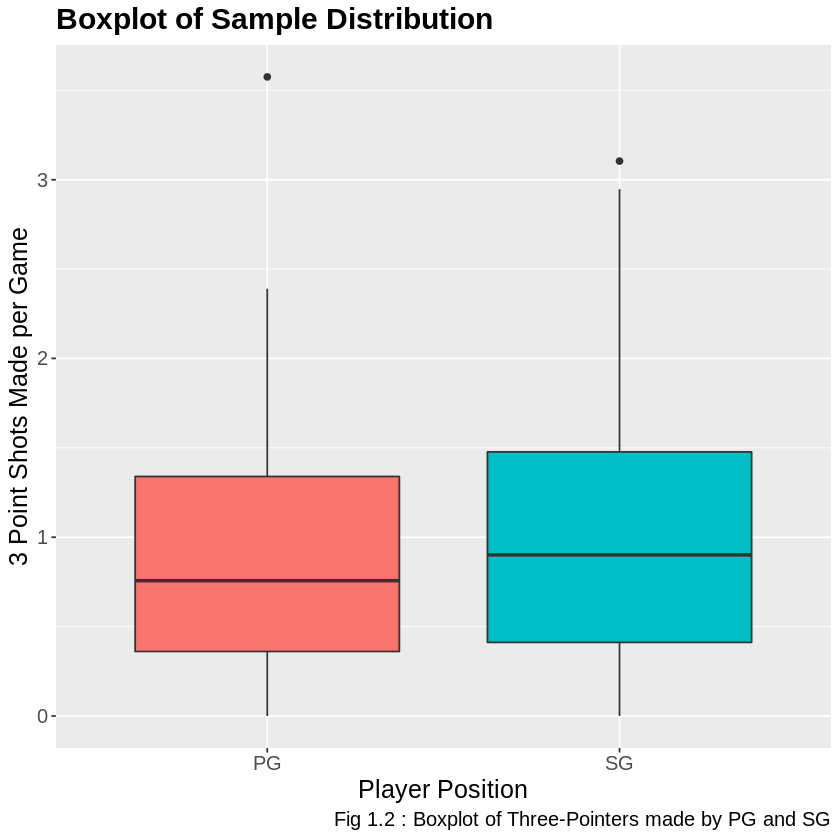

In [6]:
# Plotting the sample distribution using a histogram
options(repr.plot.width = 7, repr.plot.height = 7)

three_point_boxplot <- tidy_nba |> 
    ggplot(aes(x = pos, y = three_pts_standardized, fill = pos)) +
    geom_boxplot() + 
    ggtitle("Boxplot of Sample Distribution") +
    xlab("Player Position") +
    ylab("3 Point Shots Made per Game") +
    labs(caption = "Fig 1.2 : Boxplot of Three-Pointers made by PG and SG") +
    guides(fill = "none") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

three_point_boxplot

In Figure 1.1 and 1.2, we notice that both distributions are slightly right skewed and we see that there is an outlier in the `PG` and `SG` data. Thus, we need check the assumptions of the Central Limit Theorem:
1. The sample is drawn in a random fashion — this holds true because the data from this season is a random cluster sample, and is likely to be representative of the population.
2. The observations are independent of each other — this holds true because the population is significantly greater than the sample size, which is 184, and thus the sample size is no greater than 10% of the population size.
3. The sample size must be large enough — this holds true as well because number of the point guards in the sample is 84 and number of shooting guards is 100 from Table 1.1. Since both the samples are greater than 30, our sample size is large enough.

Since all the assumptions of the Central Limit Theorem hold, we can assume that our sample means follow a Normal distribution. Thus, mean is an appropriate choice in summary statistic.

### Hypothesis Test
Due to sampling variability, simply concluding that Shooting Guards make more 3 pointers than Point Guards from this sample is not appropriate and very unconvincing. Thus, we will perform a hypothesis test at the 5% significance level.

As shown in the distribution plots in Figure 1.1, the data right is skewed and checks all the assumptions of the Central Limit Theorem. Since we are working with quantitative variables between two independent groups, we will use a difference in means as our population parameter where $\mu_1$ is mean `three_pts_standardized` of point guards and $\mu_2$ is mean `three_pts_standardized` of shooting guards.

We will be testing the following null hypothesis $H_0$ and alternative hypothesis $H_A$:
- **Null Hypothesis:** There is no difference in the mean `three_pts_standardized` between point guards and shooting guards.<br>
    $H_0:\mu_1 - \mu_2 = 0$
- **Alternative Hypothesis:** The mean `three_pts_standardized` of shooting guards is greater than that of point guards. <br>
    $H_A:\mu_1 - \mu_2 < 0$
    
where $\mu_1$ and $\mu_2$ are the mean three-point shots made by Point Guards and Shooting Guards respectively.

Since we are comparing the means of two independent samples (point guards and shooting guards), we will perform a **two-sample t-test**. Let $n_1$ be the sample size of point guards with mean standardized three-pointers $x$ and let $n_2$ be the sample size of shooting guards with mean standardized three-pointers $y$. 

In [7]:
# Mean standardized three-pointers of point guards
x <- nba_summary |>
    filter(pos == "PG") |>
    pull(mean_three_pts)

# Sample size of point guards
n_1 <- nba_summary |>
    filter(pos == "PG") |>
    pull(n)

# Mean standardized three-pointers of shooting guards
y <- nba_summary |>
    filter(pos == "SG") |>
    pull(mean_three_pts)

# Sample size of shooting guards
n_2 <- nba_summary |>
    filter(pos == "SG") |>
    pull(n)

We compute the following test statistic:
$$
T = \frac{x-y}{\sqrt{\frac{s_x^2}{n_1}+\frac{s_y^2}{n_2}}}
$$
where $s_x^2$ is the sample variance of point guards and $s_y^2$ is the sample variance of shooting guards.

In [8]:
# Variance of standardized three-pointers of point guards
s_x <- nba_summary |>
    filter(pos == "PG") |>
    pull(var_three_pts)

# Variance of standardized three-pointers of shooting guards
s_y <- nba_summary |>
    filter(pos == "SG") |>
    pull(var_three_pts)

# Calculating the test statistic
test_stat = (x - y) / sqrt((s_x / n_1) + (s_y / n_2))

Assuming our null hypothesis is true, we will construct a null model which is a **$t$-distribution** with $df$ degrees of freedom to understand how our test statistic, difference in sample means, varies due to sampling variation under the null hypothesis. Thus, the test statistic $T$ follows a $t$-distribution with degrees of freedom:
$$
df = n_1 - n_2 - 2
$$

In [9]:
# Calculating degrees of freedom
df <- abs(n_1 - n_2 - 2)

Using the test statistic and degrees of freedom we calculated above, we will now find out the probability of obtaining a difference in means just as extreme or more extreme than the observed difference means under the null model. This is going to be the ***$p$-value***.

In [20]:
# Calculating the p-value
p_value <- 2 * pt(test_stat, df)
tibble(p_value)

p_value
<dbl>
0.2448948


Since the p-value $\approx$ 0.2449 is significantly greater than the significance level 0.05, we fail to reject the null hypothesis. We will visualize this $p$-value with our t-distribution.

Warning message:
“Check to make sure the conditions have been met for the theoretical method. {infer} currently does not check these for you.”


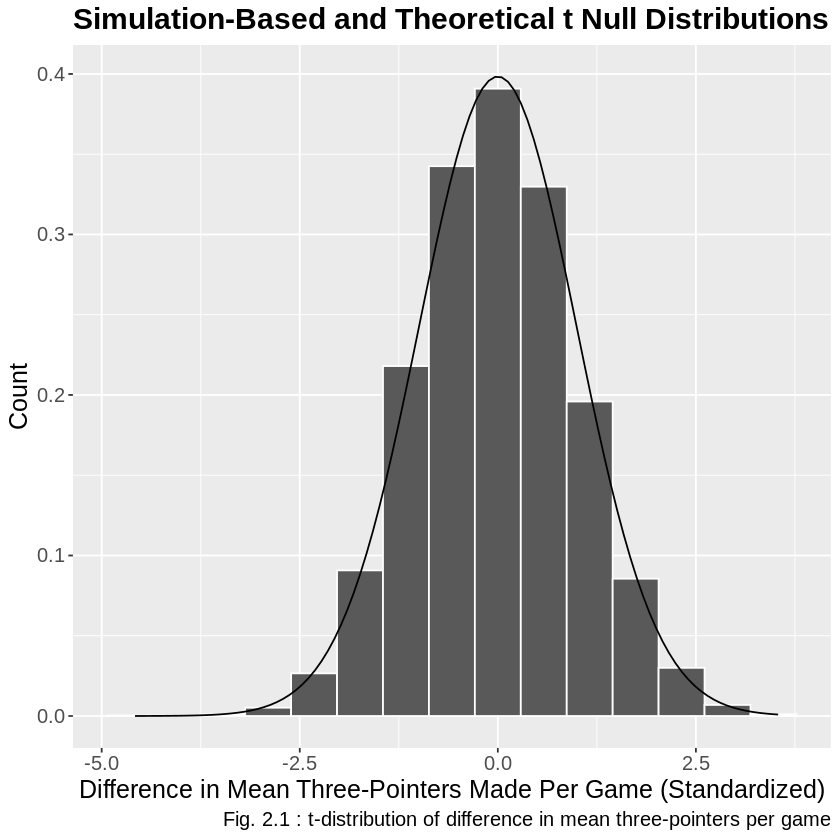

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7)

# Generating the null distribution
null_dist <- tidy_nba |>
    specify(formula = three_pts_standardized ~ pos) |>
    hypothesize(null = "independence") |>
    generate(reps = 5000, type = "permute") |>
    calculate(stat = "t", c("PG", "SG"))

# Plotting the null model
null_model <- visualize(null_dist, method = "both") +
    ylab("Count") +
    xlab("Difference in Mean Three-Pointers Made Per Game (Standardized)") +
    labs(caption = "Fig. 2.1 : t-distribution of difference in mean three-pointers per game") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

null_model

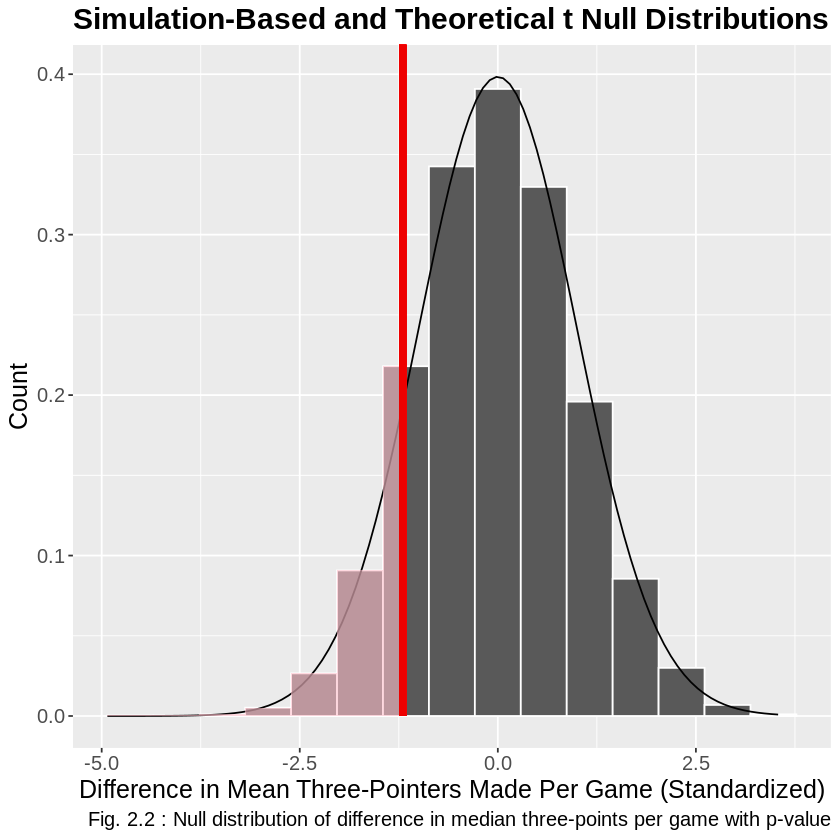

In [17]:
options(repr.plot.width = 7, repr.plot.height = 7)

# Observed difference in median of standardized three-pointers
obs_two_sample_t <- tidy_nba |>
    specify(formula = three_pts_standardized ~ pos) |>
    calculate(stat = "t", c("PG", "SG"))

# Visualizing the p-value on the t-distribution
p_value_model <- null_model +
    shade_p_value(obs_stat = obs_two_sample_t, direction = "left") +
    labs(caption = "Fig. 2.2 : Null distribution of difference in median three-points per game with p-value") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

p_value_model

As seen in Figure 2.2, it seems we would often observe no difference in means of standardized three-pointers made if the null hypothesis is assumed to be true. Thus, there is insufficient evidence to conclude that shooting guards score more three-pointers than point guards.

### Comparison with Confidence Interval

We will construct a 1 - $\alpha$ = 95% confidence interval using a bootstrap approach and determine where the observed difference in means falls within that interval. This is another method of performing the same hypothesis test above at the 5% significance level.

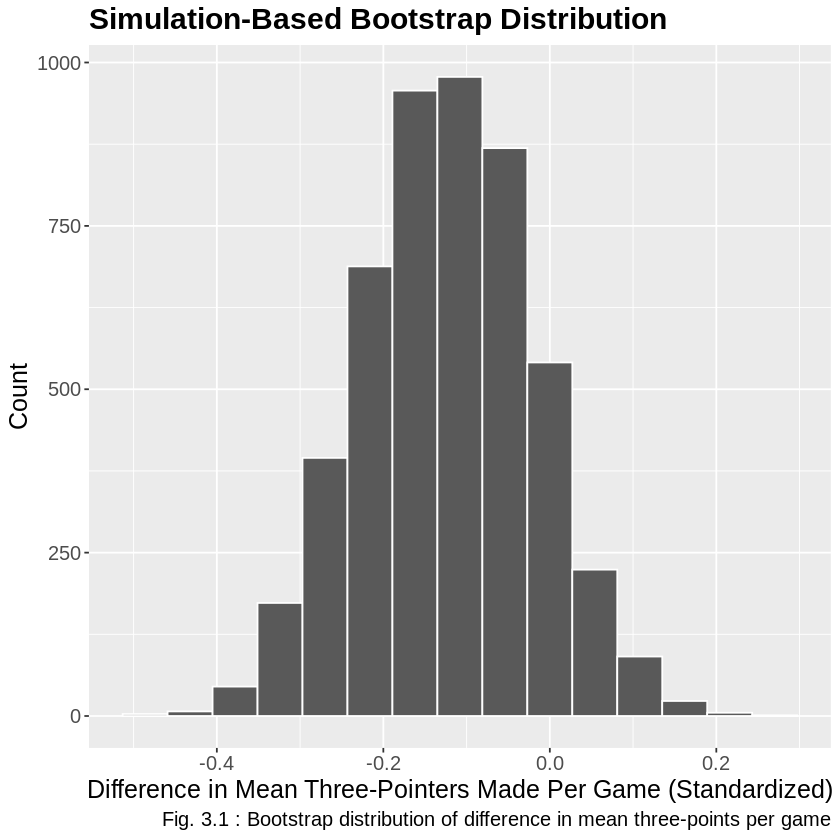

In [14]:
options(repr.plot.width = 7, repr.plot.height = 7)

# Generating the bootstrap distribution
diff_in_means_bootstrap <- tidy_nba |> 
    specify(formula = three_pts_standardized ~ pos) |> 
    generate(reps = 5000, type = "bootstrap") |> 
    calculate(stat = "diff in means", order = c("PG", "SG"))

# Plotting bootstrap distribution
bootstrap_dist <- visualize(diff_in_means_bootstrap) +
    ylab("Count") +
    xlab("Difference in Mean Three-Pointers Made Per Game (Standardized)") +
    labs(caption = "Fig. 3.1 : Bootstrap distribution of difference in mean three-points per game") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

bootstrap_dist

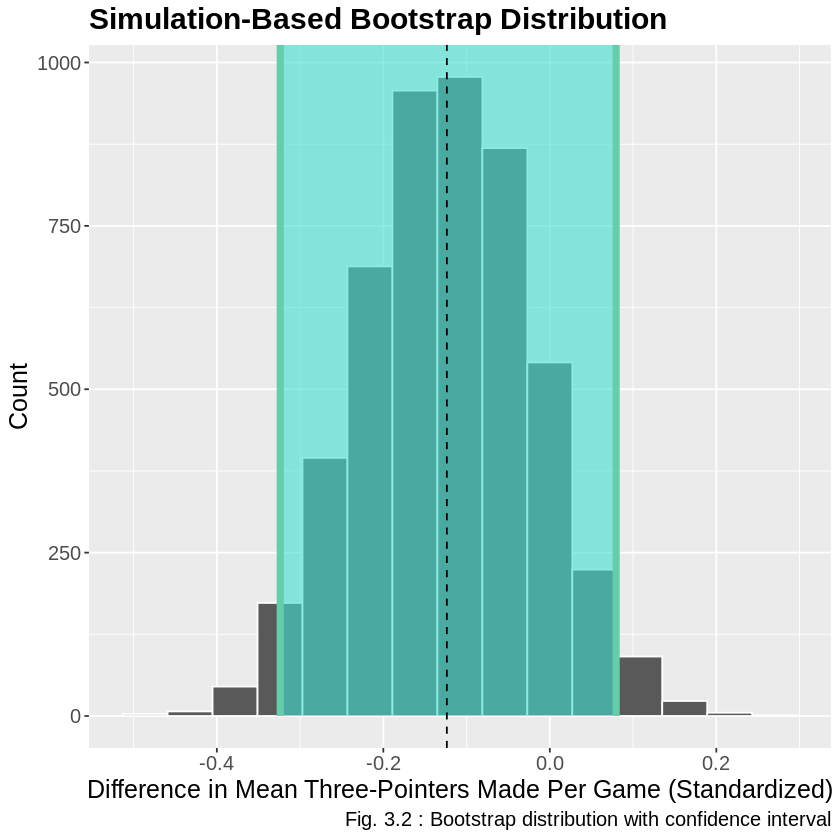

In [15]:
options(repr.plot.width = 7, repr.plot.height = 7)

# Getting the 95% percentile confidence interval
diff_in_means_ci <- diff_in_means_bootstrap |> 
    get_ci(level = 0.95, type = "percentile")

# Visualizing the confidence interval and observed test statistic
diff_in_means_ci_plot <- diff_in_means_bootstrap |> 
    visualize() +
    shade_ci(endpoints = diff_in_means_ci) + 
    geom_vline(xintercept = as.numeric(obs_diff_mean), linetype = "dashed") +
    ylab("Count") +
    xlab("Difference in Mean Three-Pointers Made Per Game (Standardized)") +
    labs(caption = "Fig. 3.2 : Bootstrap distribution with confidence interval") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

diff_in_means_ci_plot

As seen in Figure 3.2, the observered test statistic falls within the 95% (1 - $\alpha$) confidence interval which means that we fail to reject the null hypothesis. This conclusion coincides with the result we obtained during our hypotheiss test above.

### Discussion 

As shown above, both our p-value of 11.26% and a difference of 0 falling within our 95% confidence interval for the difference in medians both suggest that there is no significant difference in the number of 3-point shots made by point guards and shooting guards in the 2017-28 NBA season, which suggests that both groups are rougly equally proficent in shooting three-pointers. This result is what we expected to find, with the rise in three-point shots made by point guards, we predicted it would be difficult for shooting gaurds to outclass them in today's game.  The results of this study could result in coaches re-evaluating the types of players they place in each position. With two high scoring positions, it could now be an option for coaches to sacrifice the defensive capabilites for shooting capabilites in some players to help them win more games. A subsequent study could test whether teams with a higher scoring point guard, win more games than teams with a higher scoring shooting guard.

### References

1. Analysis of the final actions used in basketball during formative years ... (n.d.). Retrieved March 16, 2023, from https://www.researchgate.net/publication/255994752_Analysis_of_the_final_actions_used_in_basketball_during_formative_years_according_to_player's_position 

2. Camli, M. B. (2018, November 4). NBA Player stats 2017-2018. Kaggle. Retrieved March 16, 2023, from https://www.kaggle.com/datasets/mcamli/nba17-18 

3. Examining positional difference in basketball players’ field goal ... (n.d.). Retrieved March 16, 2023, from https://journals.sagepub.com/doi/abs/10.1177/17479541221096772 